In [1]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt

utc=pytz.UTC # work with offset-naive and offset-aware datetimes

f1='dump_time_stamps_vec.csv'
data1=read_csv(f1, skiprows=10000, parse_dates=True, squeeze=True, sep=',', header=None)
datalen = len(data1.values)

def check_bracket(str):
    if str == None:
        return "0"
    if str.startswith('['):
        return str[1:]
    if str.endswith(']'):
        return str[:-1]
    return str

# for bluestore latency
x_bs_lat = []
y_bs_lat = []


# process the time stamps
for i in range(datalen-1):
    # simple writes
    #if len(data1.values[i,:]) == len(data1.values[i+1,:]) and data1.values[i,2] == 'simple_s':
    if data1.values[i,2] == 'simple_s':
        # for first ctx
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        simple_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        aio_done1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc) #ts2
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc) #ts3
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        simple_e1 = parser.parse(check_bracket(data1.values[i,11])).replace(tzinfo=utc)
        # for second ctx
        '''ctr_ctx2 = parser.parse(check_bracket(data1.values[i+1,1]))
        simple_s2 = parser.parse(check_bracket(data1.values[i+1,3]))
        aio_done2 = parser.parse(check_bracket(data1.values[i+1,5]))
        flush_cmt_s2 = parser.parse(check_bracket(data1.values[i+1,7]))
        flush_cmt_e2 = parser.parse(check_bracket(data1.values[i+1,9]))
        simple_e2 = parser.parse(check_bracket(data1.values[i+1,11]))'''
        # sanity check of timestamps
        if simple_s1 < ctr_ctx1 or aio_done1 < simple_s1 or flush_cmt_s1 < aio_done1 or flush_cmt_e1 < flush_cmt_s1 or simple_e1 < flush_cmt_e1:
            print("simple writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_simple = simple_e1 - simple_s1
        x_bs_lat.append(simple_s1)
        y_bs_lat.append(bluestore_lat_simple.total_seconds())
        
        # spikes
#         if bluestore_lat_simple.total_seconds() > 0.05:
#             print("bluestore_lat_simple",bluestore_lat_simple.total_seconds(),", simple_start",check_bracket(data1.values[i,3]))

    # deferred writes
    elif data1.values[i,2] == 'deferred_s':
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        deferred_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        deferred_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        # sanity check of timestamps
        if deferred_s1 < ctr_ctx1 or flush_cmt_s1 < deferred_s1 or flush_cmt_e1 < flush_cmt_s1 or deferred_e1 < flush_cmt_e1:
            print("deferred writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_deferred = deferred_e1 - deferred_s1
        x_bs_lat.append(deferred_s1)
        y_bs_lat.append(bluestore_lat_deferred.total_seconds())
        
        # spikes
#         if bluestore_lat_deferred.total_seconds() > 0.05:
#             print("bluestore_lat_deferred",bluestore_lat_deferred.total_seconds(),", deferred_start",check_bracket(data1.values[i,3]))

if2='flush_job_timestamps.csv'     # Compaction for L0
if3='compact_job_timestamps.csv'   # Compaction for other levels
id2=read_csv(if2, parse_dates=True, squeeze=True, sep=',', header=None)
id3=read_csv(if3, parse_dates=True, squeeze=True, sep=',', header=None)

id2len = len(id2.values)
id3len = len(id3.values)

x2_compact = [] # flush(L0) timestamps
x3_compact = [] # compact(>= L1) timestamps
y2_compact = [] # dummp y value
y3_compact = [] # dummp y value
w2_compact = [] # durations(width of compaction)
w3_compact = [] # durations(width of compaction)

for i in range(id2len):
    x2_compact.append((parser.parse(id2.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w2_compact.append(id2.values[i,5]/1000000)
    y2_compact.append(0.05)
for i in range(id3len):
    x3_compact.append((parser.parse(id3.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w3_compact.append(id3.values[i,5]/1000000)
    y3_compact.append(0.05)
print('Done')

Done


In [40]:
# CDF
def plot_cdf(data, title, x_label, x_log=False):
    fig, ax = plt.subplots(figsize=(8, 4))
    if x_log:
        plt.xscale('log')
    n, bins, patches = ax.hist(
        data,
        1_000_000,
        density=True,
        histtype='step',
        cumulative=True,
        label='cdf'
    )
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel('Likelihood of occurrence')
    if not x_log:
        plt.xlim(left=0)
    plt.show()

def number_of_writes_before(write_times, marked_times):
    number_of_writes = len(write_times)
    number_of_writes_before = []
    write_time_index = 0
    for marked_time in marked_times:
        count = 0
        while write_time_index < number_of_writes and write_times[write_time_index] < marked_time:
            write_time_index += 1
            count += 1
        number_of_writes_before.append(count)
    return number_of_writes_before

In [41]:
import warnings
import scipy.stats as st
import statsmodels as sm

def best_fit_distribution(data, bins=200, ax=None, title='res'):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        st.johnsonsu,
        st.genlogistic,
        st.nct,
        st.t,
        st.norm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    fits = {}
    num = len(DISTRIBUTIONS)
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    # end
                except Exception:
                    pass

                param_names = (distribution.shapes + ', loc, scale').split(', ') if distribution.shapes else ['loc', 'scale']
                param_str = ', '.join(['{}={:0.2f}'.format(k, v) for k, v in zip(param_names, params)])
                dist_str = '{}({})'.format(distribution.name, param_str)
                dist_data = {'name': distribution.name, 'sse': sse, 'params': dist_str}
                fits[distribution.name] = dist_data
                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass
    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


def find_best_dist(data, title, x_log=False):
    # Load data from statsmodels datasets
    # data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    data = pd.Series(data)

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=500, density=True, alpha=0.5, color='b')
    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 1_000, ax, title=title)
    best_dist = getattr(st, best_fit_name)

    # Update plots
    # ax.set_ylim(dataYLim)
    ax.set_title(title)
    ax.set_xlabel(u'Latency')
    ax.set_ylabel('Frequency')
    if x_log:
        plt.xscale('log')
    plt.show()
    # Make PDF with best params
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=1_000, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(title + ' best dist: ' + dist_str)
    ax.set_xlabel(u'Latency')
    ax.set_ylabel('Frequency')
    if x_log:
        plt.xscale('log')
    plt.show()

In [42]:
import datetime
def split_latencies(
    times, latancies, 
    l0_compaction_starts, l0_compaction_durations, 
    l1_compaction_starts, l1_compaction_durations,
    other_compaction_starts = [], other_compaction_durations = []):
    l0_affected_latencies = []
    l1_affected_latencies = []
    other_affected_latencies = []
    other_latencies = []
    l0_compaction_ends = [l0_compaction_starts[i] + datetime.timedelta(0,l0_compaction_durations[i]) for i in range(len(l0_compaction_starts))]
    l1_compaction_ends = [l1_compaction_starts[i] + datetime.timedelta(0,l1_compaction_durations[i]) for i in range(len(l1_compaction_starts))]
    other_compaction_ends = [other_compaction_starts[i] + datetime.timedelta(0,other_compaction_durations[i]) for i in range(len(other_compaction_starts))]
    for i in range(len(times)):
        time = times[i]
        affected = False
        for j in range(len(l0_compaction_starts)):
            if l0_compaction_starts[j] <= time <= l0_compaction_ends[j]:
                affected = True
                l0_affected_latencies.append(latancies[i])
                break
        for j in range(len(l1_compaction_starts)):
            if l1_compaction_starts[j] <= time <= l1_compaction_ends[j]:
                affected = True
                l1_affected_latencies.append(latancies[i])
                break
        for j in range(len(other_compaction_starts)):
            if other_compaction_starts[j] <= time <= other_compaction_ends[j]:
                affected = True
                other_affected_latencies.append(latancies[i])
                break
        if not affected:
            other_latencies.append(latancies[i])
    return l0_affected_latencies, l1_affected_latencies, other_affected_latencies, other_latencies, l0_compaction_ends, l1_compaction_ends

# Latency and Compactions

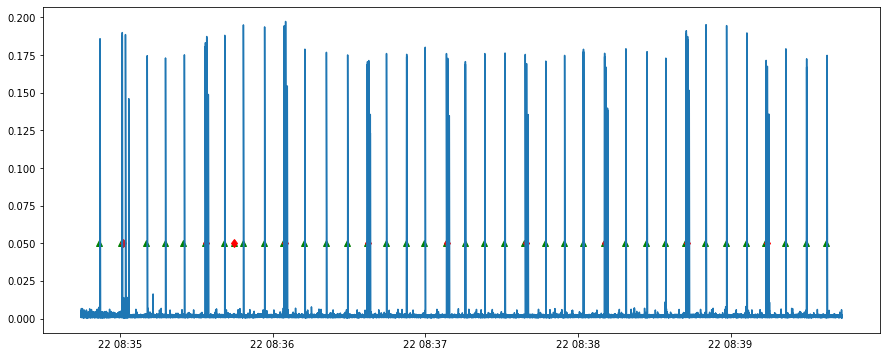

In [43]:
fig= plt.figure(figsize=(15,6))
plt.plot(x2_compact, y2_compact, label='4096 KiB',marker='^', c='g', linestyle='')
plt.plot(x3_compact, y3_compact, label='4096 KiB',marker='d', c='r', linestyle='')
         
plt.plot(x_bs_lat, y_bs_lat, label='bluestore')
#ax.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series')
#plt.legend()
plt.show()
plt.close()

# Number of write operations between every compaction at different levels

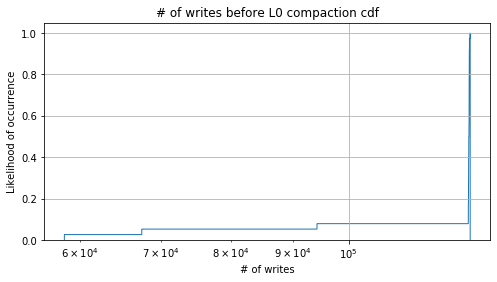

125718.0


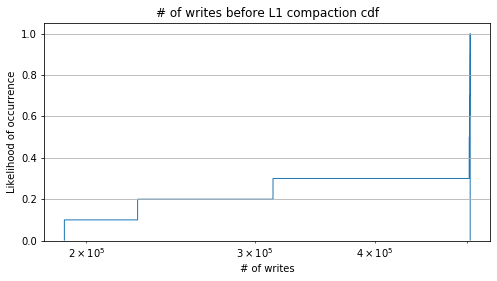

502553.5


In [44]:
number_of_writes_before_flush = number_of_writes_before(x_bs_lat, x2_compact)
plot_cdf(number_of_writes_before_flush, '# of writes before L0 compaction cdf', '# of writes', x_log=True)
print(statistics.median(number_of_writes_before_flush))

number_of_writes_before_compaction = number_of_writes_before(x_bs_lat, x3_compact)
plot_cdf(number_of_writes_before_compaction, '# of writes before L1 compaction cdf', '# of writes', x_log=True)
print(statistics.median(number_of_writes_before_compaction))
plt.close()


# Duration of every compaction at different levels

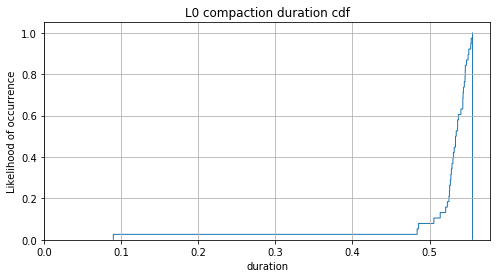

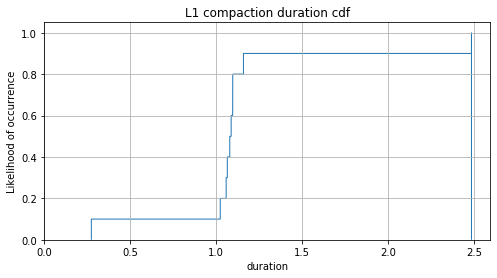

In [47]:
plot_cdf(w2_compact, 'L0 compaction duration cdf', 'duration', x_log=False)

plot_cdf(w3_compact, 'L1 compaction duration cdf', 'duration', x_log=False)

plt.close()


# (All / Not affected / Compaction affected) Latencies

In [46]:
import statistics

l0_affected_latencies, l1_affected_latencies, other, other_latencies, l0_compaction_ends, l1_compaction_ends = split_latencies(
    x_bs_lat, y_bs_lat, 
    x2_compact, w2_compact, 
    x3_compact, w3_compact )

def stats(data, title):
    print(title+':')
    print('\t len:'+str(len(data)))
    print('\t mean:'+str(statistics.mean(data)))
    print('\t median:'+str(statistics.median(data)))
    #print('\t mode:'+str(statistics.mode(data)))
    print('\t variance:'+str(statistics.variance(data)))
    print('\t max:'+str(max(data)))
    print('\t min:'+str(min(data)))

non_spike_latency_median = statistics.median(other_latencies)
    

stats(y_bs_lat, 'all latencies')
stats(other_latencies, 'not affected')
stats(l0_affected_latencies, 'l0_affected_latencies')
stats(l1_affected_latencies, 'l1_affected_latencies')




all latencies:
	 len:4719897
	 mean:0.0015257133873895978
	 median:0.001398
	 variance:1.671551924906388e-05
	 max:0.19729
	 min:0.000364
not affected:
	 len:4363096
	 mean:0.0014288269341311765
	 median:0.001406
	 variance:9.57117431787397e-08
	 max:0.016292
	 min:0.000364
l0_affected_latencies:
	 len:227968
	 mean:0.002675617240138967
	 median:0.001272
	 variance:0.00024504901849089795
	 max:0.19515
	 min:0.00049
l1_affected_latencies:
	 len:128833
	 mean:0.0027721612319824888
	 median:0.001372
	 variance:0.0001713259960930273
	 max:0.19729
	 min:0.000517


# Compaction duration correction

In [48]:
def find_real_compaction_duration(times, latencies, 
    l0_compaction_starts, l0_compaction_durations, 
    l1_compaction_starts, l1_compaction_durations ):
    l0_compaction_ends = [l0_compaction_starts[i] + datetime.timedelta(0,l0_compaction_durations[i]) for i in range(len(l0_compaction_starts))]
    l1_compaction_ends = [l1_compaction_starts[i] + datetime.timedelta(0,l1_compaction_durations[i]) for i in range(len(l1_compaction_starts))]
    L0_real_compaction_starts = []
    L0_real_compaction_duration = []
    L1_real_compaction_starts = []
    L1_real_compaction_duration = []
    other_real_compaction_starts = []
    other_real_compaction_duration = []
    j = 0
    for i in range(len(l0_compaction_starts)):
        while times[j] <= l0_compaction_ends[i]:
            if l0_compaction_starts[i] <= times[j] and latencies[j] >= 0.05:
                L0_real_compaction_starts.append(times[j])
                L0_real_compaction_duration.append(latencies[j] - non_spike_latency_median)
                break
            j += 1
    j = 0
    for i in range(len(l1_compaction_starts)):
        while times[j] <= l1_compaction_ends[i]:
            if l1_compaction_starts[i] <= times[j] and latencies[j] >= 0.05:
                L1_real_compaction_starts.append(times[j])
                L1_real_compaction_duration.append(latencies[j] - non_spike_latency_median)
                break
            j += 1
        j += 48
        while times[j] <= l1_compaction_ends[i]:
            if l1_compaction_starts[i] <= times[j] and latencies[j] >= 0.05:
                other_real_compaction_starts.append(times[j])
                other_real_compaction_duration.append(latencies[j] - non_spike_latency_median)
                break
            j += 1
    return L0_real_compaction_starts, L0_real_compaction_duration, L1_real_compaction_starts, L1_real_compaction_duration, other_real_compaction_starts, other_real_compaction_duration

L0_real_compaction_starts, L0_real_compaction_duration, L1_real_compaction_starts, L1_real_compaction_duration, other_real_compaction_starts, other_real_compaction_duration = find_real_compaction_duration(x_bs_lat, y_bs_lat, 
    x2_compact, w2_compact, 
    x3_compact, w3_compact)

Compaction L0 >> from 2020-06-22 08:34:51.844318+00:00 to 2020-06-22 08:34:52.387838+00:00
spikes: 48


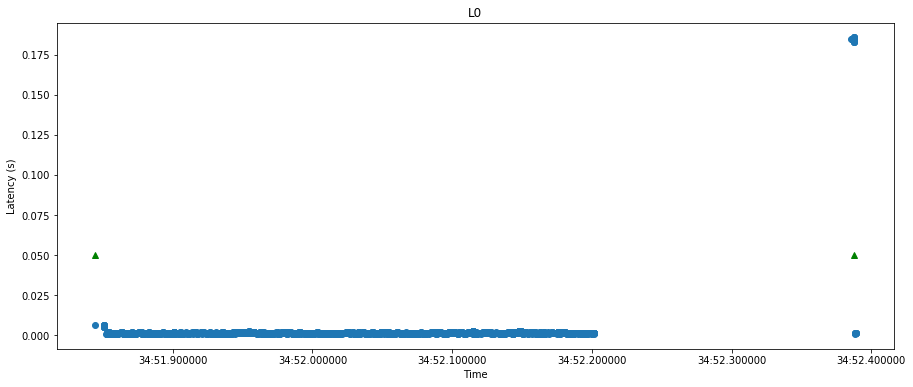

Compaction L0 >> from 2020-06-22 08:35:00.590502+00:00 to 2020-06-22 08:35:01.134487+00:00
spikes: 48


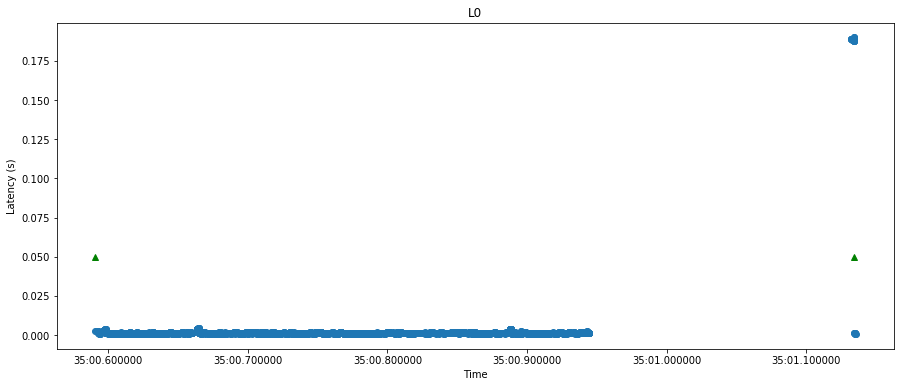

Compaction L0 >> from 2020-06-22 08:35:10.406428+00:00 to 2020-06-22 08:35:10.933438+00:00
spikes: 48


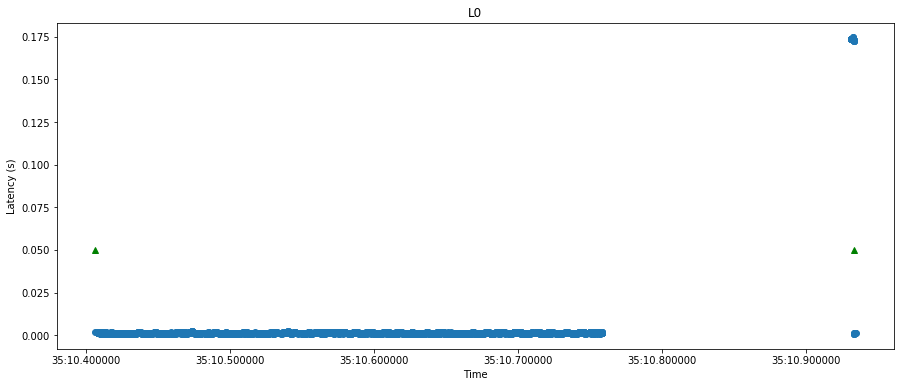

Compaction L0 >> from 2020-06-22 08:35:17.619530+00:00 to 2020-06-22 08:35:18.105309+00:00
spikes: 48


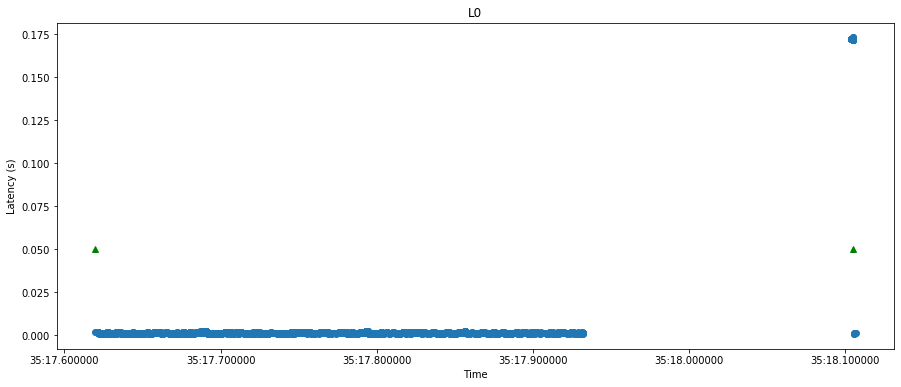

Compaction L0 >> from 2020-06-22 08:35:24.997642+00:00 to 2020-06-22 08:35:25.528034+00:00
spikes: 48


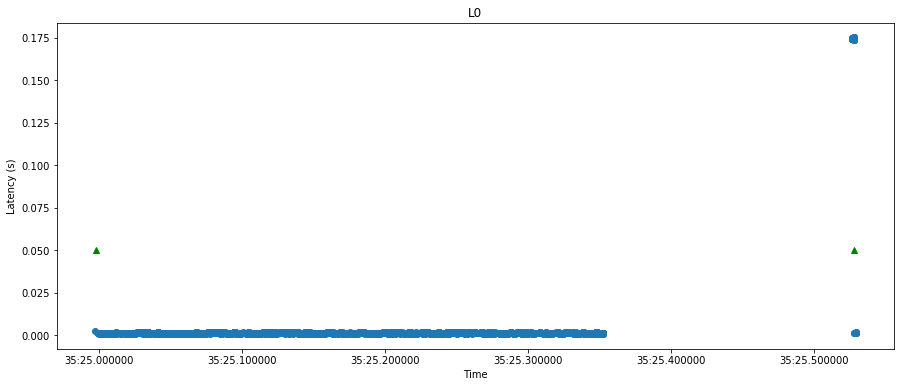

Compaction L0 >> from 2020-06-22 08:35:33.265061+00:00 to 2020-06-22 08:35:33.811099+00:00
spikes: 48


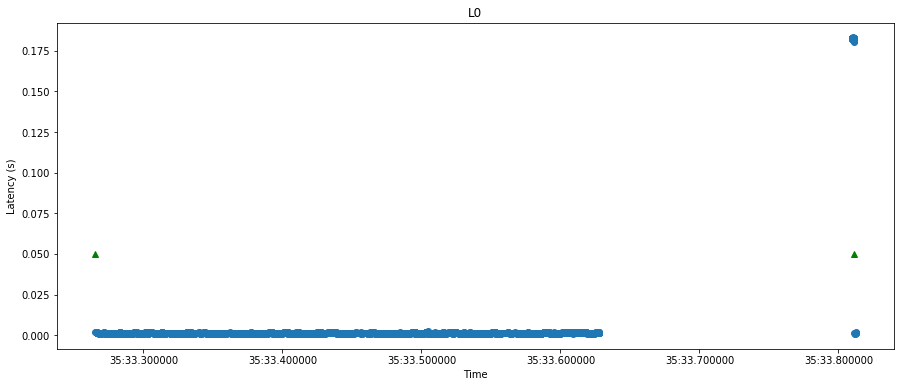

Compaction L0 >> from 2020-06-22 08:35:40.883501+00:00 to 2020-06-22 08:35:41.409643+00:00
spikes: 48


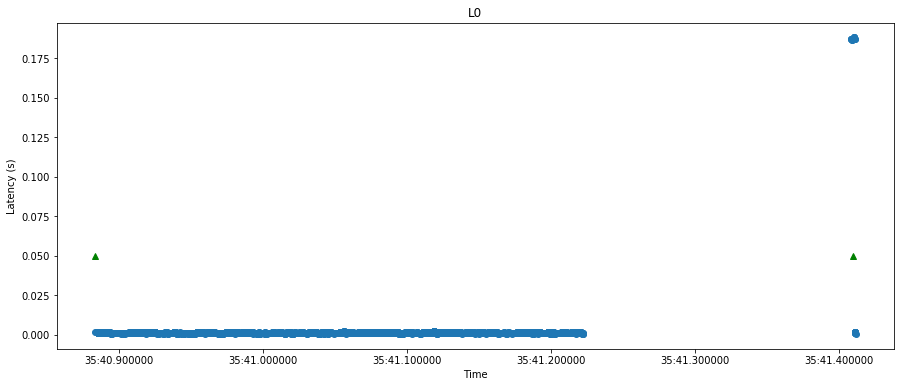

Compaction L0 >> from 2020-06-22 08:35:44.808603+00:00 to 2020-06-22 08:35:44.898423+00:00
spikes: 0


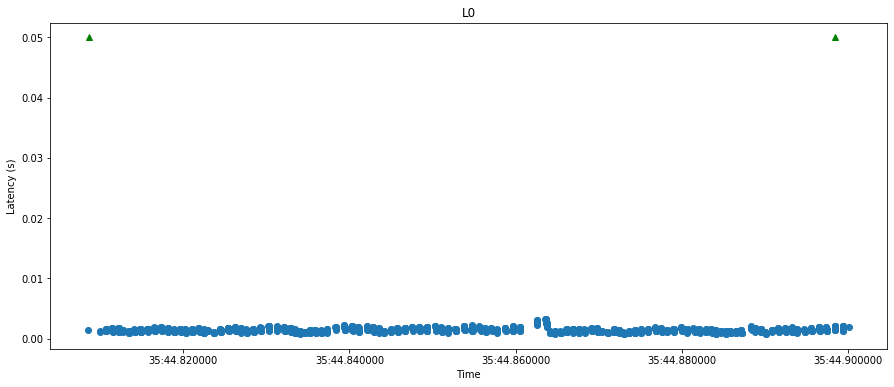

Compaction L0 >> from 2020-06-22 08:35:48.188110+00:00 to 2020-06-22 08:35:48.738097+00:00
spikes: 48


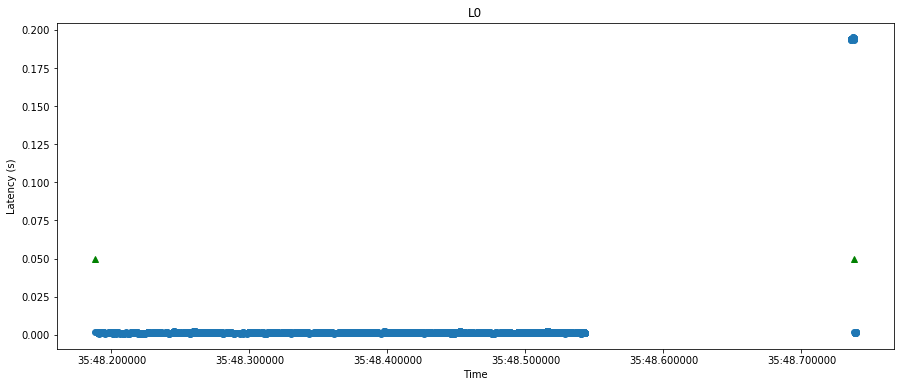

Compaction L0 >> from 2020-06-22 08:35:56.526747+00:00 to 2020-06-22 08:35:57.073002+00:00
spikes: 48


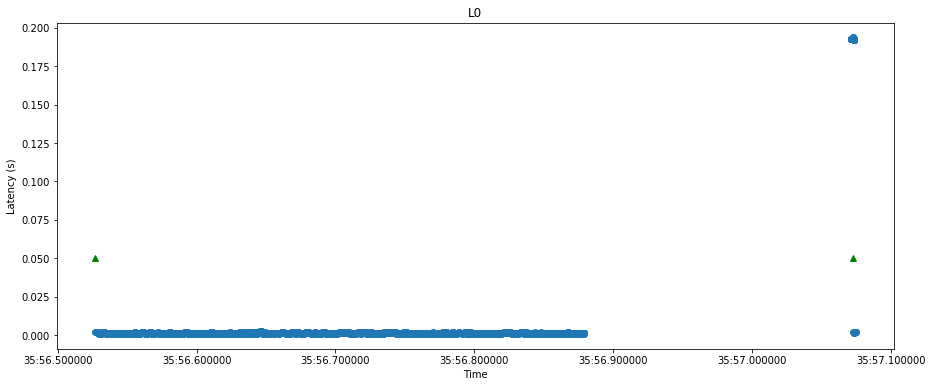

Compaction L0 >> from 2020-06-22 08:36:04.218500+00:00 to 2020-06-22 08:36:04.771955+00:00
spikes: 48


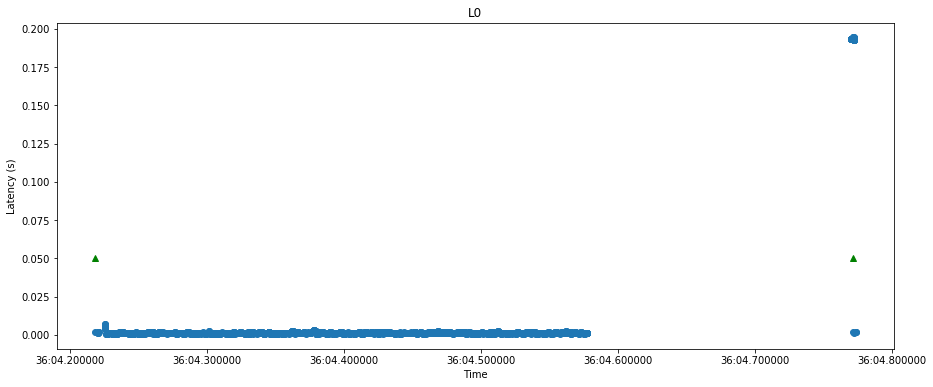

Compaction L0 >> from 2020-06-22 08:36:12.350138+00:00 to 2020-06-22 08:36:12.884751+00:00
spikes: 48


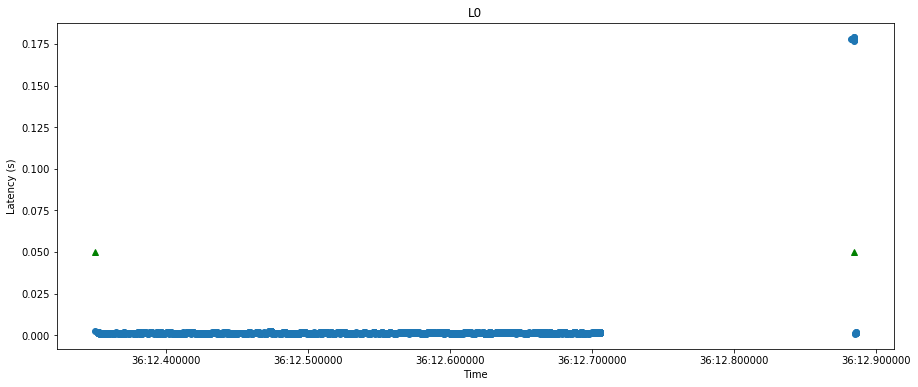

Compaction L0 >> from 2020-06-22 08:36:20.809957+00:00 to 2020-06-22 08:36:21.340922+00:00
spikes: 48


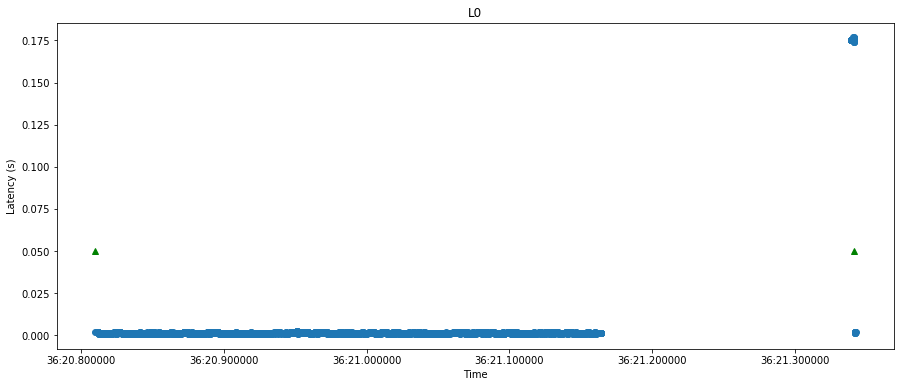

Compaction L0 >> from 2020-06-22 08:36:29.149843+00:00 to 2020-06-22 08:36:29.683515+00:00
spikes: 48


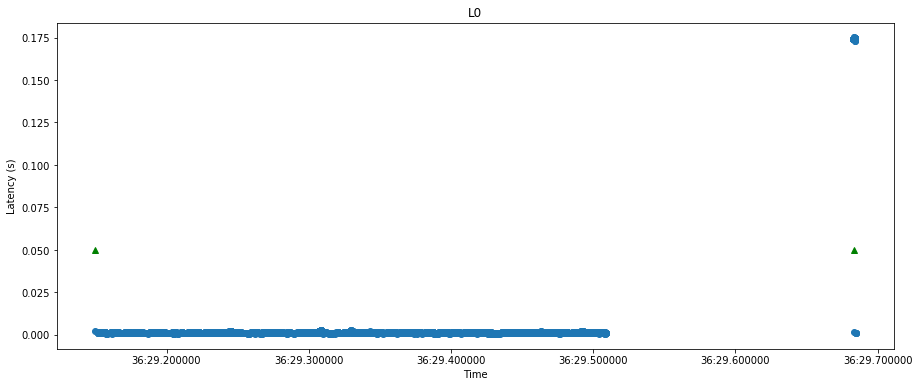

Compaction L0 >> from 2020-06-22 08:36:36.957835+00:00 to 2020-06-22 08:36:37.478700+00:00
spikes: 48


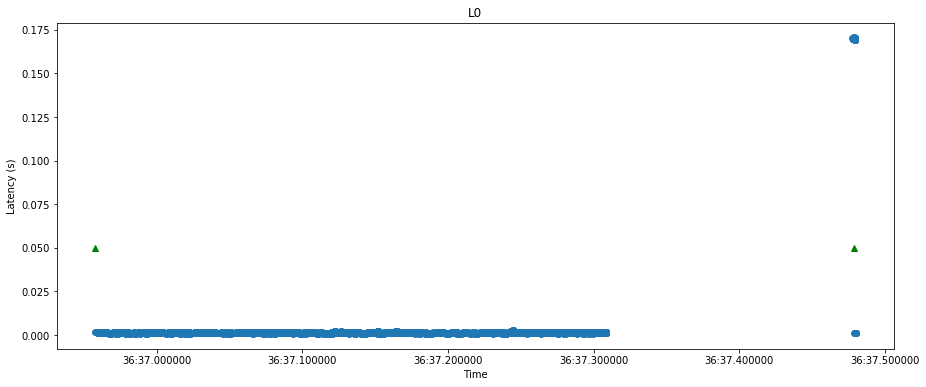

Compaction L0 >> from 2020-06-22 08:36:44.448270+00:00 to 2020-06-22 08:36:44.953884+00:00
spikes: 48


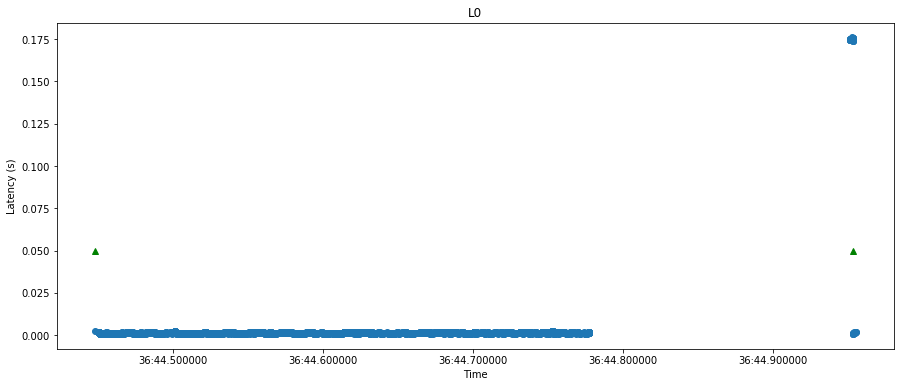

Compaction L0 >> from 2020-06-22 08:36:52.341467+00:00 to 2020-06-22 08:36:52.889321+00:00
spikes: 48


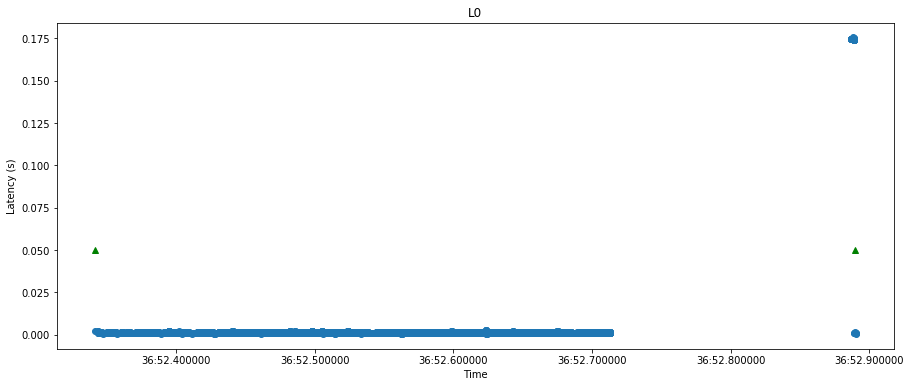

Compaction L0 >> from 2020-06-22 08:36:59.632653+00:00 to 2020-06-22 08:37:00.177767+00:00
spikes: 48


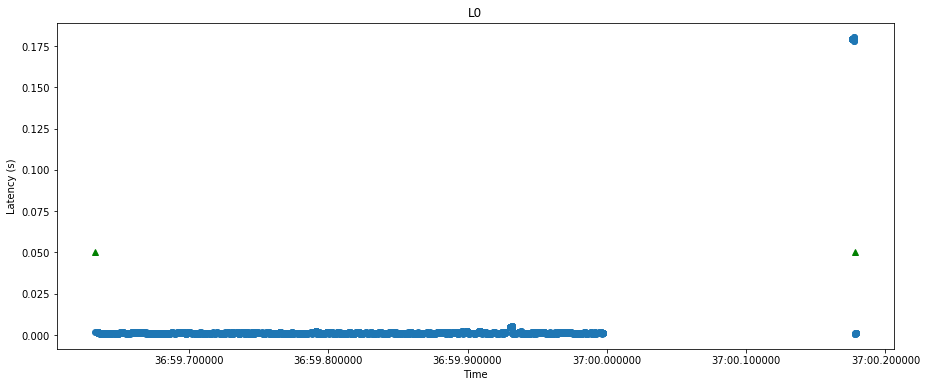

Compaction L0 >> from 2020-06-22 08:37:07.971728+00:00 to 2020-06-22 08:37:08.514845+00:00
spikes: 48


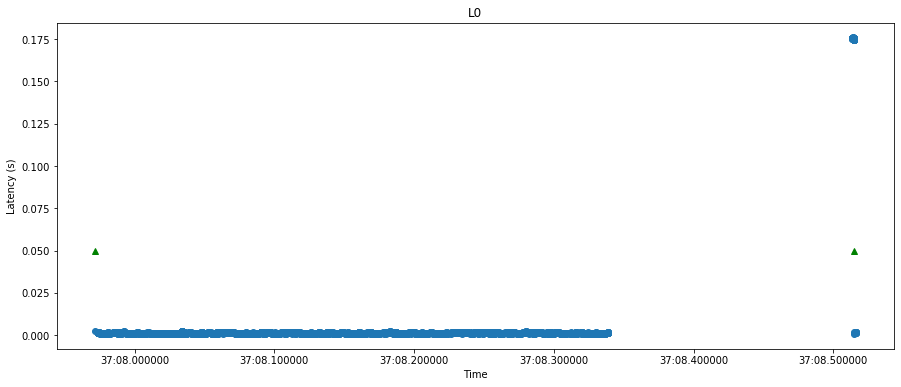

Compaction L0 >> from 2020-06-22 08:37:15.463063+00:00 to 2020-06-22 08:37:15.946985+00:00
spikes: 48


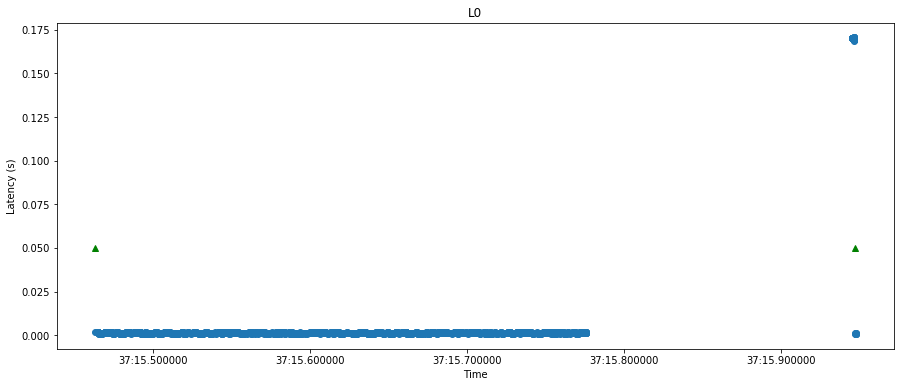

Compaction L0 >> from 2020-06-22 08:37:23.035357+00:00 to 2020-06-22 08:37:23.571766+00:00
spikes: 48


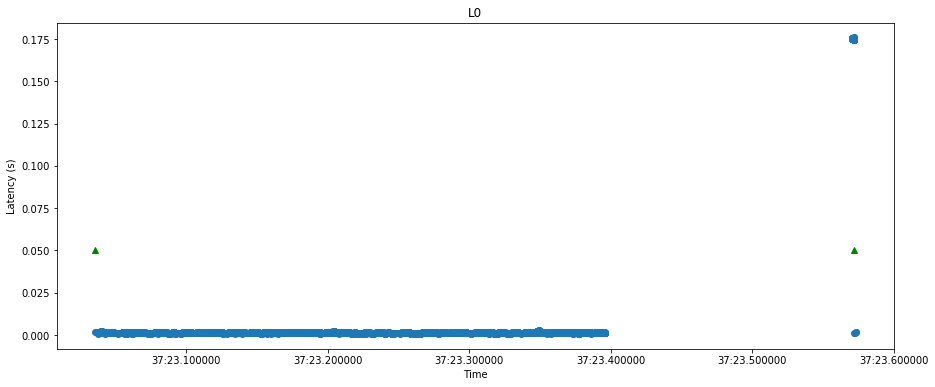

Compaction L0 >> from 2020-06-22 08:37:31.007512+00:00 to 2020-06-22 08:37:31.535175+00:00
spikes: 48


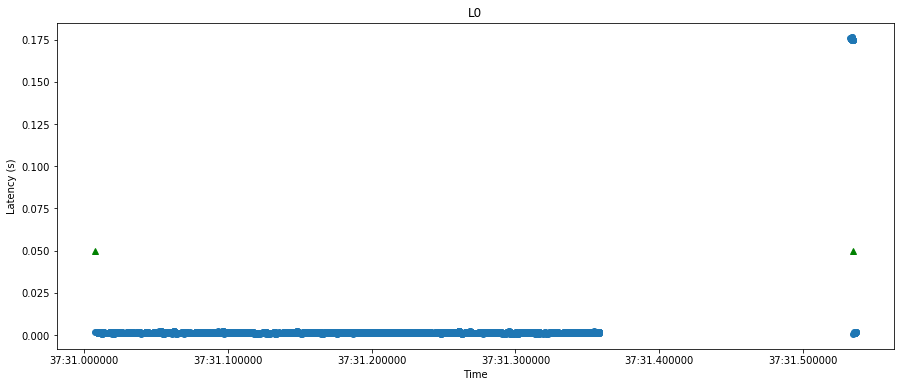

Compaction L0 >> from 2020-06-22 08:37:38.954371+00:00 to 2020-06-22 08:37:39.483494+00:00
spikes: 48


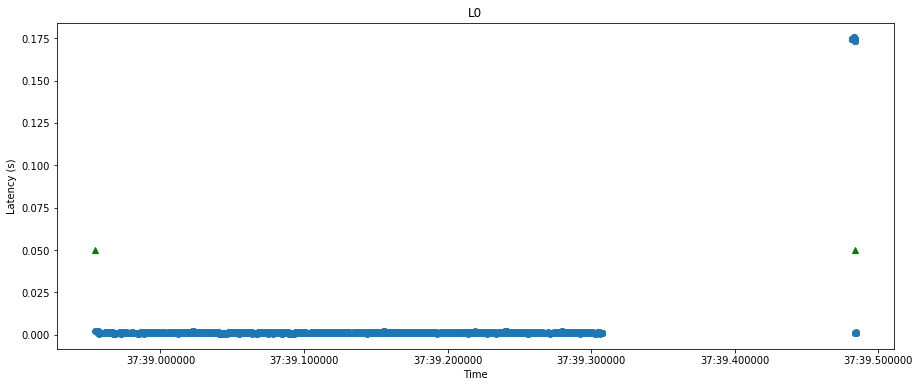

Compaction L0 >> from 2020-06-22 08:37:47.040819+00:00 to 2020-06-22 08:37:47.554668+00:00
spikes: 48


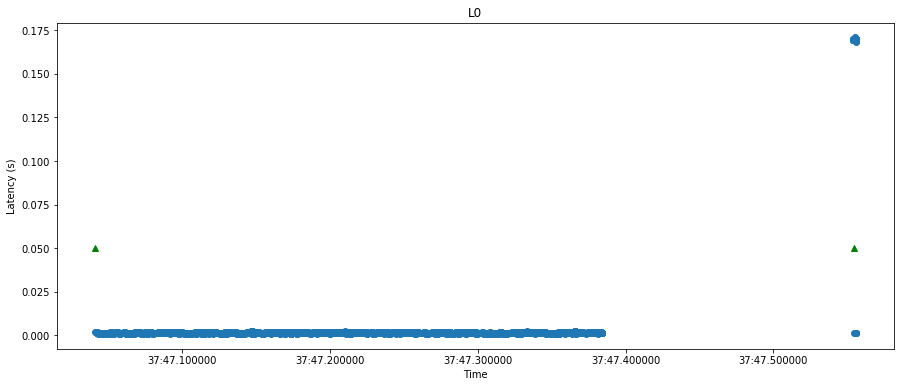

Compaction L0 >> from 2020-06-22 08:37:54.420892+00:00 to 2020-06-22 08:37:54.946709+00:00
spikes: 48


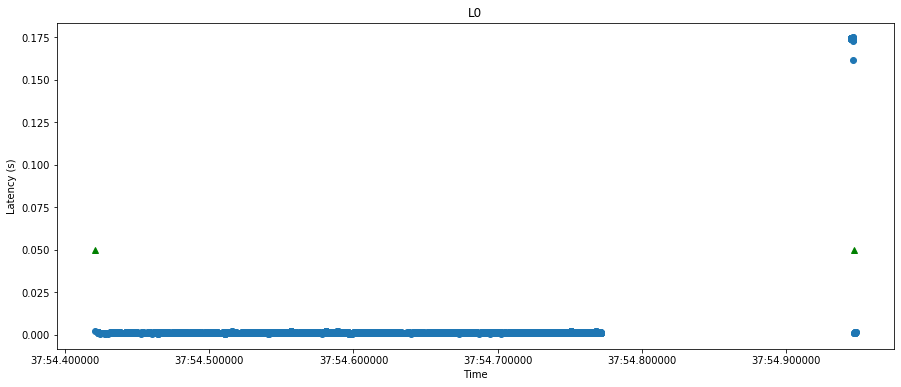

Compaction L0 >> from 2020-06-22 08:38:01.833391+00:00 to 2020-06-22 08:38:02.365386+00:00
spikes: 48


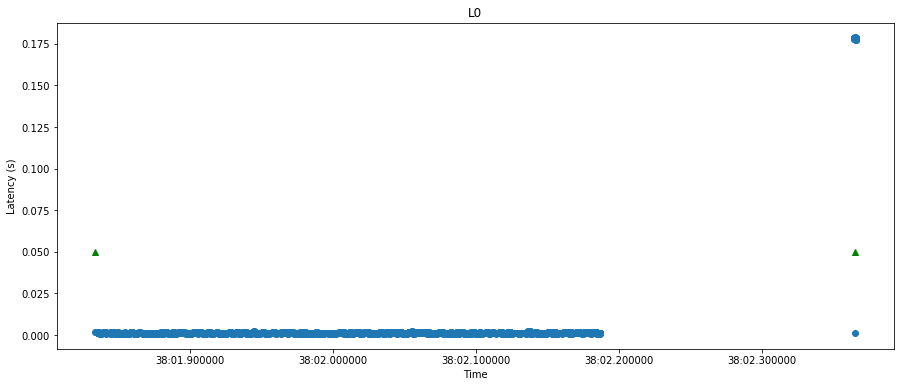

Compaction L0 >> from 2020-06-22 08:38:10.141511+00:00 to 2020-06-22 08:38:10.677959+00:00
spikes: 48


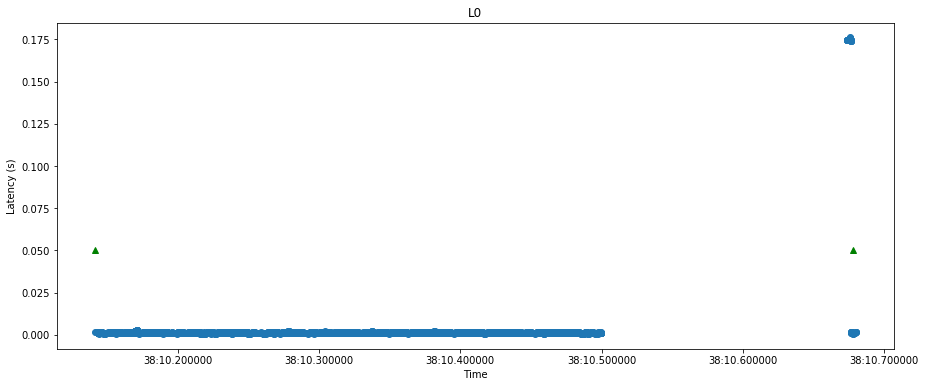

Compaction L0 >> from 2020-06-22 08:38:18.498187+00:00 to 2020-06-22 08:38:19.041393+00:00
spikes: 48


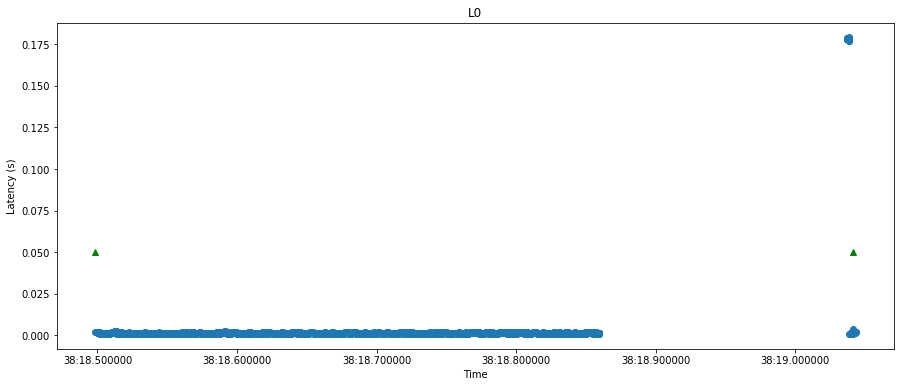

Compaction L0 >> from 2020-06-22 08:38:26.811371+00:00 to 2020-06-22 08:38:27.348796+00:00
spikes: 48


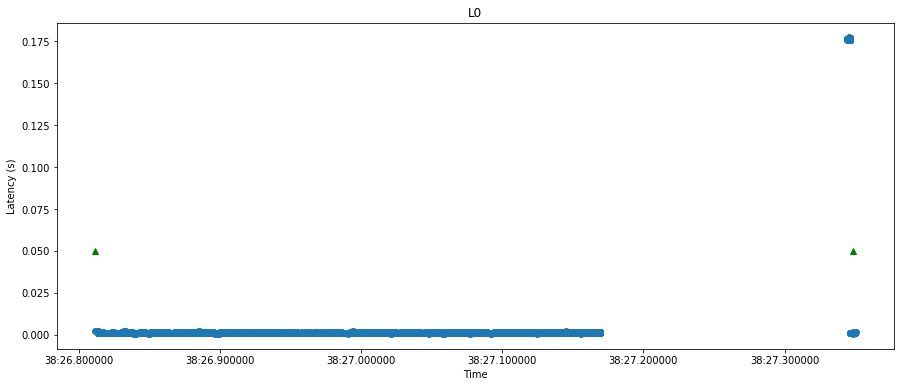

Compaction L0 >> from 2020-06-22 08:38:34.188079+00:00 to 2020-06-22 08:38:34.721749+00:00
spikes: 48


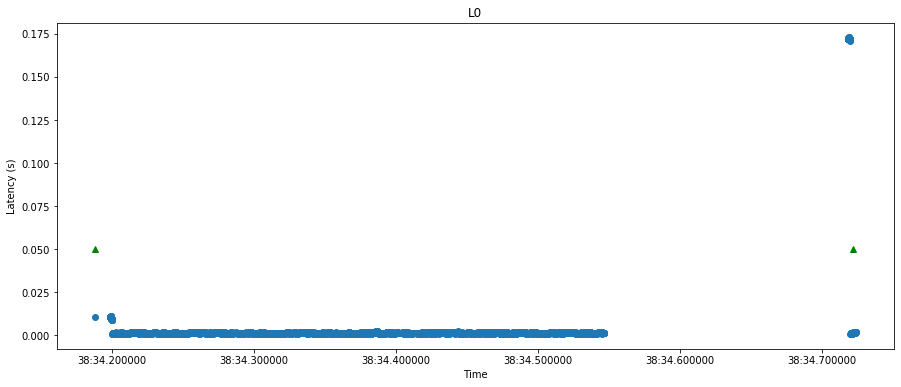

Compaction L0 >> from 2020-06-22 08:38:42.236825+00:00 to 2020-06-22 08:38:42.792572+00:00
spikes: 48


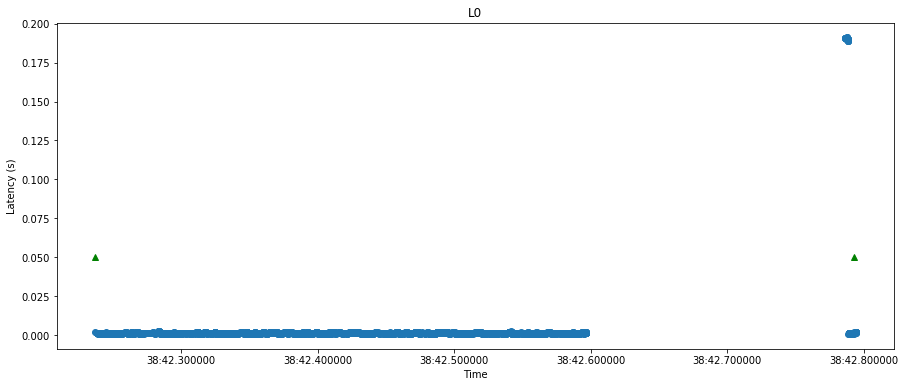

Compaction L0 >> from 2020-06-22 08:38:49.998232+00:00 to 2020-06-22 08:38:50.549179+00:00
spikes: 48


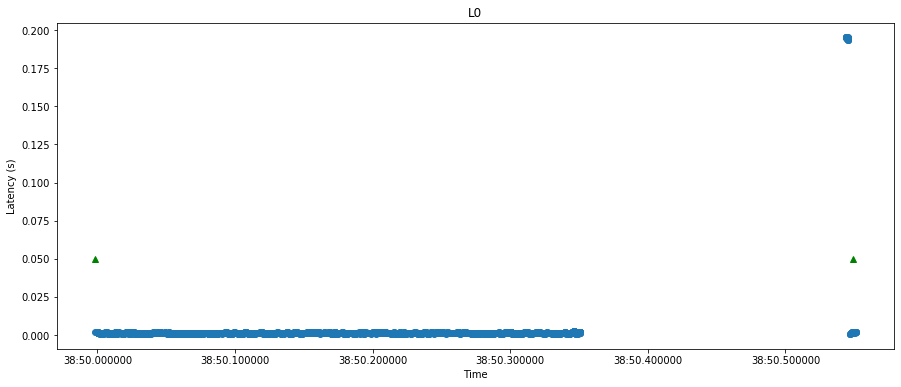

Compaction L0 >> from 2020-06-22 08:38:58.075592+00:00 to 2020-06-22 08:38:58.629653+00:00
spikes: 48


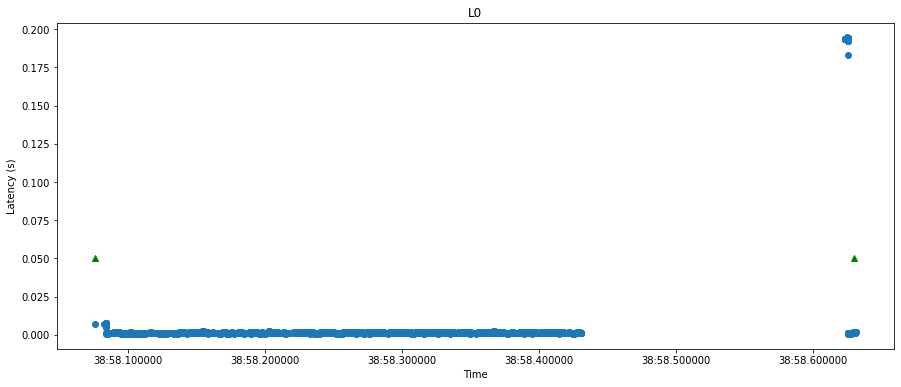

Compaction L0 >> from 2020-06-22 08:39:06.055299+00:00 to 2020-06-22 08:39:06.601718+00:00
spikes: 48


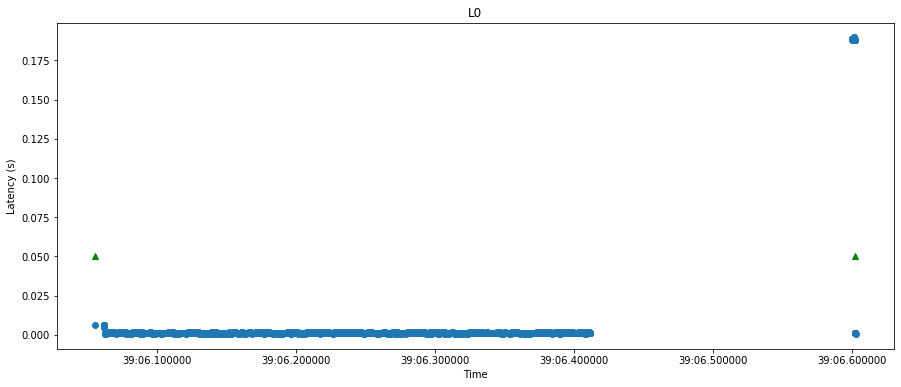

Compaction L0 >> from 2020-06-22 08:39:13.620191+00:00 to 2020-06-22 08:39:14.143308+00:00
spikes: 48


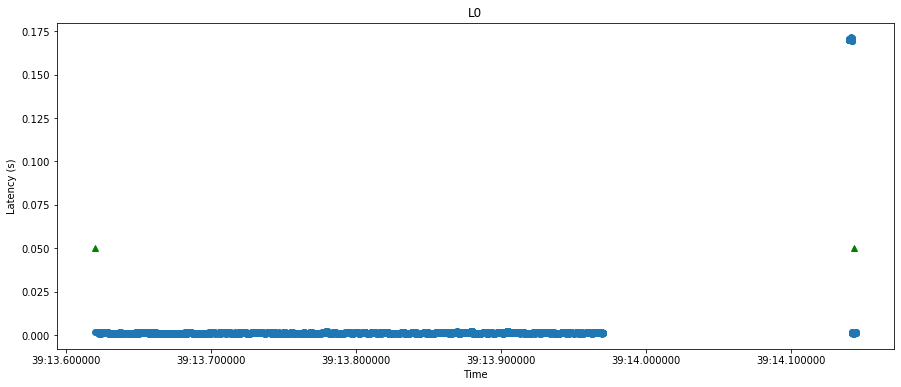

Compaction L0 >> from 2020-06-22 08:39:21.362798+00:00 to 2020-06-22 08:39:21.903464+00:00
spikes: 48


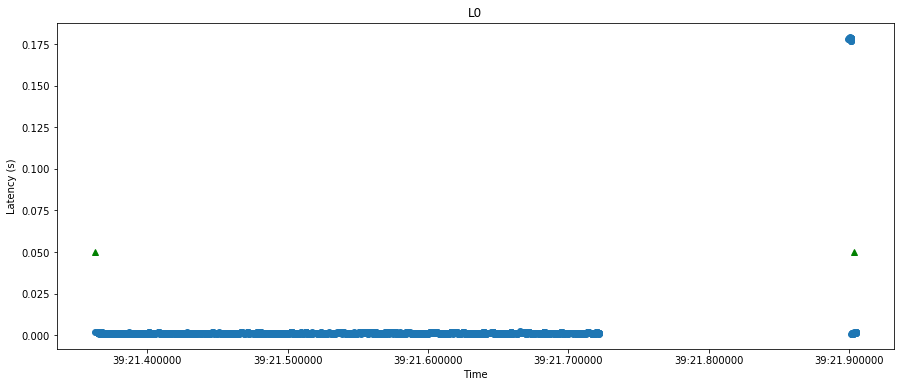

Compaction L0 >> from 2020-06-22 08:39:29.535880+00:00 to 2020-06-22 08:39:30.061087+00:00
spikes: 48


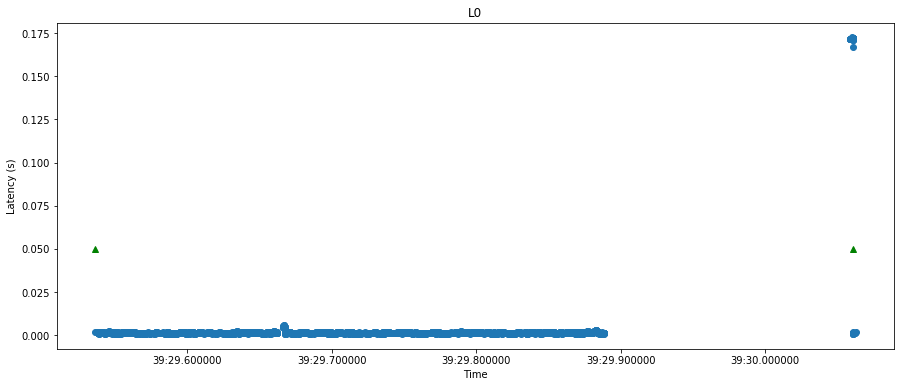

Compaction L0 >> from 2020-06-22 08:39:37.567558+00:00 to 2020-06-22 08:39:38.095858+00:00
spikes: 48


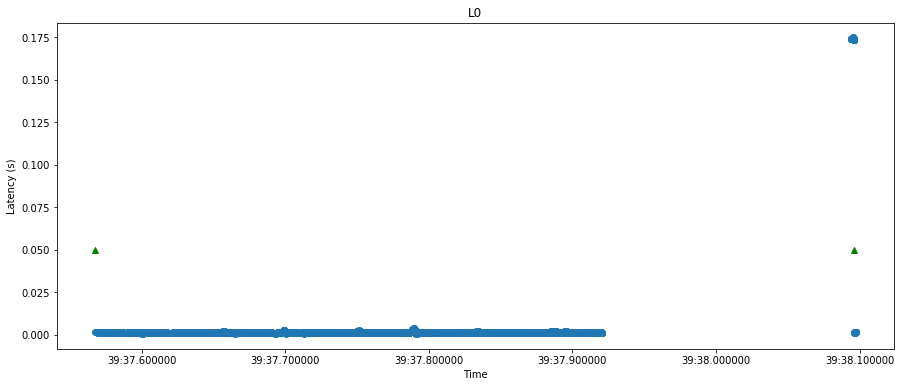

Compaction L1 >> from 2020-06-22 08:35:01.141244+00:00 to 2020-06-22 08:35:03.626521+00:00
spikes: 96


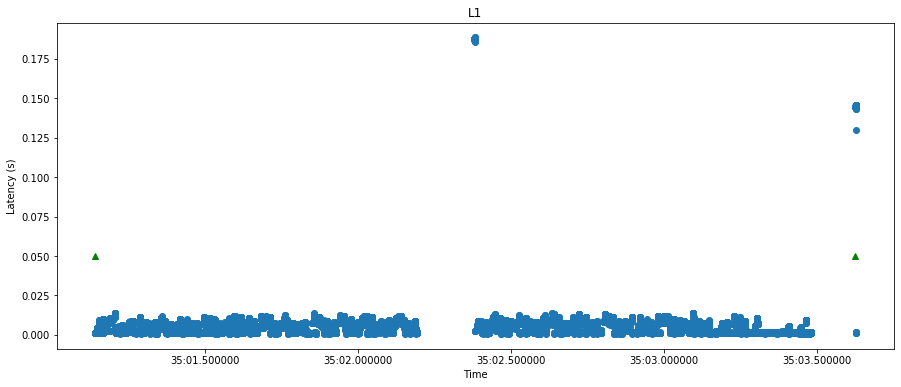

Compaction L1 >> from 2020-06-22 08:35:33.812394+00:00 to 2020-06-22 08:35:34.909568+00:00
spikes: 96


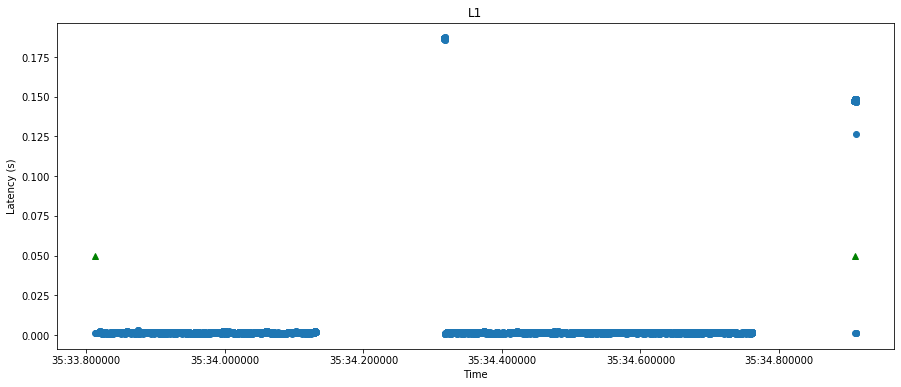

Compaction L1 >> from 2020-06-22 08:35:44.956000+00:00 to 2020-06-22 08:35:45.230845+00:00
spikes: 0


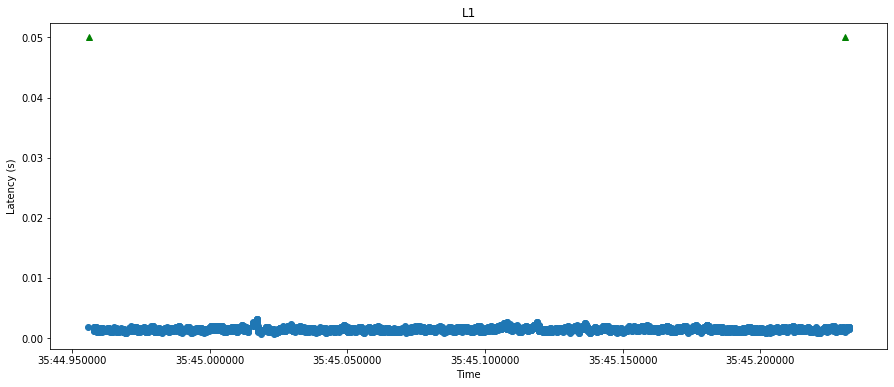

Compaction L1 >> from 2020-06-22 08:36:04.777862+00:00 to 2020-06-22 08:36:05.937173+00:00
spikes: 96


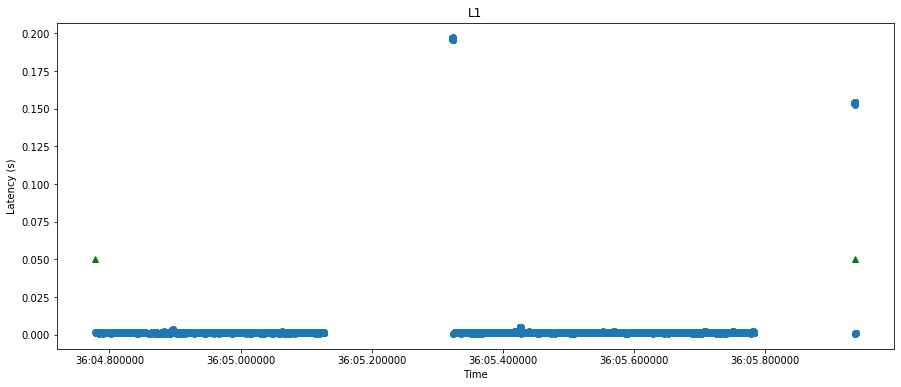

Compaction L1 >> from 2020-06-22 08:36:37.479697+00:00 to 2020-06-22 08:36:38.538480+00:00
spikes: 96


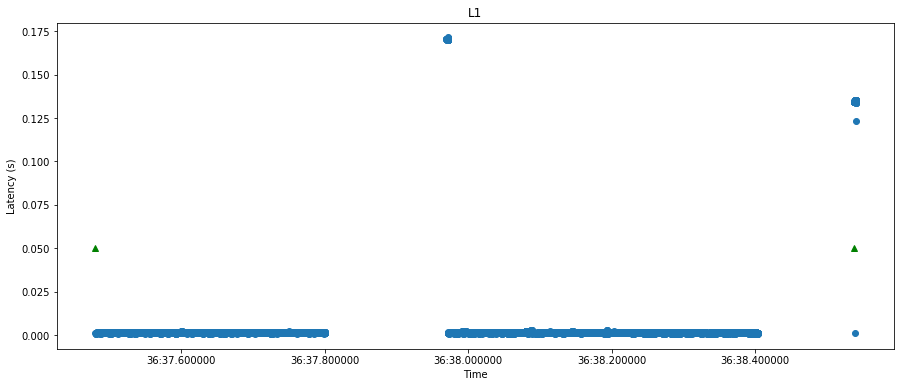

Compaction L1 >> from 2020-06-22 08:37:08.518547+00:00 to 2020-06-22 08:37:09.584128+00:00
spikes: 96


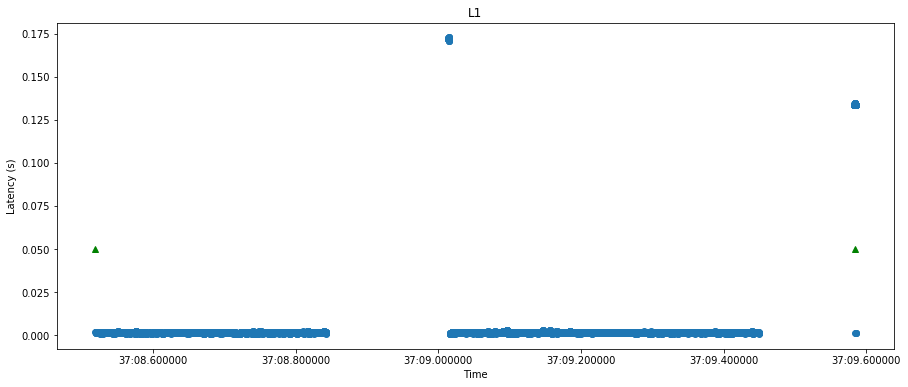

Compaction L1 >> from 2020-06-22 08:37:39.484837+00:00 to 2020-06-22 08:37:40.572753+00:00
spikes: 96


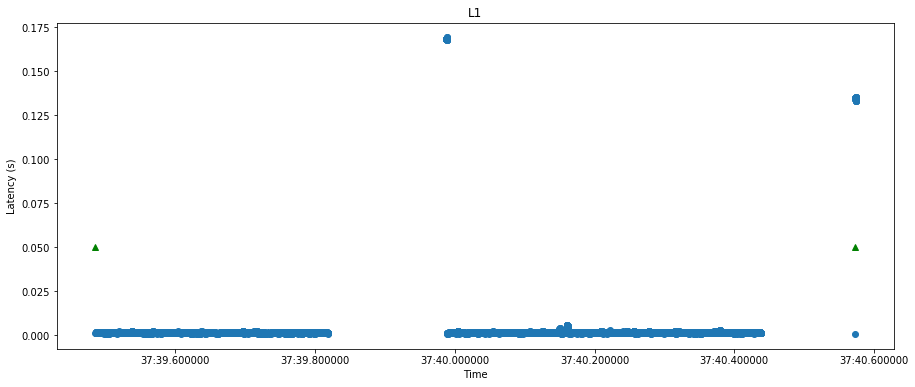

Compaction L1 >> from 2020-06-22 08:38:10.679237+00:00 to 2020-06-22 08:38:11.759054+00:00
spikes: 96


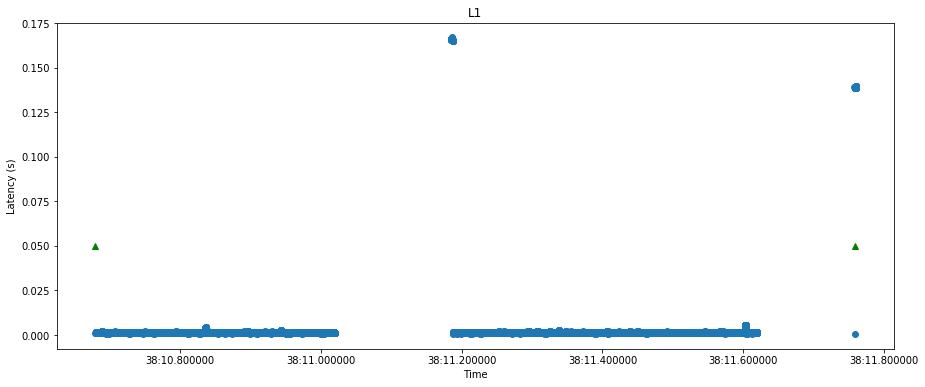

Compaction L1 >> from 2020-06-22 08:38:42.794057+00:00 to 2020-06-22 08:38:43.890689+00:00
spikes: 96


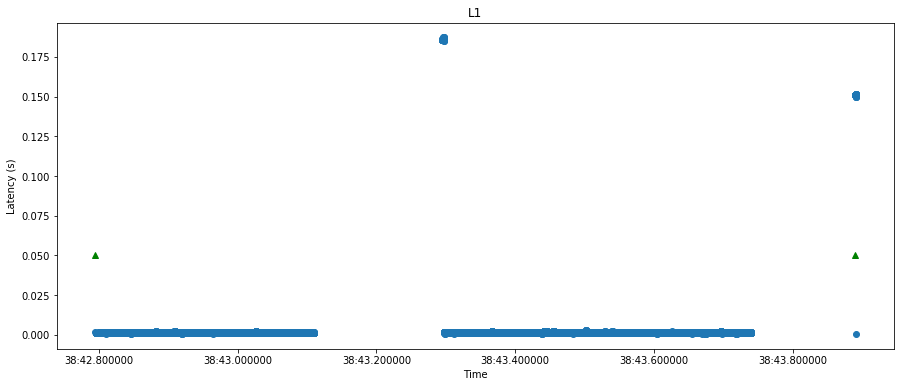

Compaction L1 >> from 2020-06-22 08:39:14.144694+00:00 to 2020-06-22 08:39:15.169098+00:00
spikes: 96


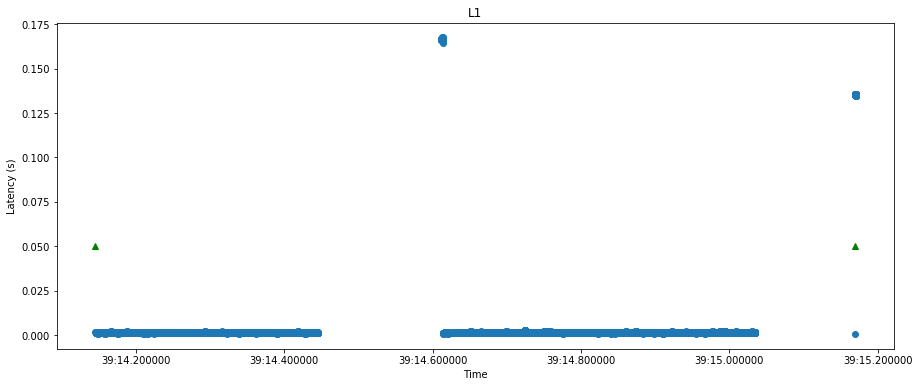

In [52]:
def plot_compaction_windows(times, latencies, compaction_start_times, compaction_end_times, title, extra=0):
    j = 0
    for i in range(len(compaction_start_times)):
        time = []
        lat = []
        found = False
        while times[j] <= compaction_end_times[i]:
            if compaction_start_times[i] <= times[j]:
                if not found:
                    found = True
                    for k in range(np.maximum(0, j - extra),j):
                        time.append(times[k])
                        lat.append(latencies[k])
                time.append(times[j] + datetime.timedelta(0,latencies[j]))
                lat.append(latencies[j])
            j += 1
        for k in range(j, np.minimum(len(times), j + extra)):
            time.append(times[k])
            lat.append(latencies[k])
        print('Compaction '+title+' >> from '+str(compaction_start_times[i]) +' to '+str(compaction_end_times[i]))
        fig, ax = plt.subplots(figsize=(15, 6))
        plt.plot([compaction_start_times[i], compaction_end_times[i]], [0.05, 0.05], label='4096 KiB',marker='^', c='g', linestyle='')
        plt.plot(time, lat, linestyle='',marker='o')
        ax.set_title(title)
        ax.set_xlabel(u'Time')
        ax.set_ylabel('Latency (s)')
        spikes = [l for l in lat if l >= 0.05]
        print('spikes: '+str(len(spikes)))
        plt.show()

plot_compaction_windows(x_bs_lat, y_bs_lat, x2_compact, l0_compaction_ends, 'L0', extra=1)
plot_compaction_windows(x_bs_lat, y_bs_lat, x3_compact, l1_compaction_ends, 'L1', extra=1)
plt.close()

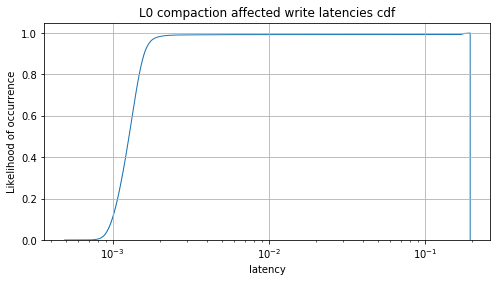

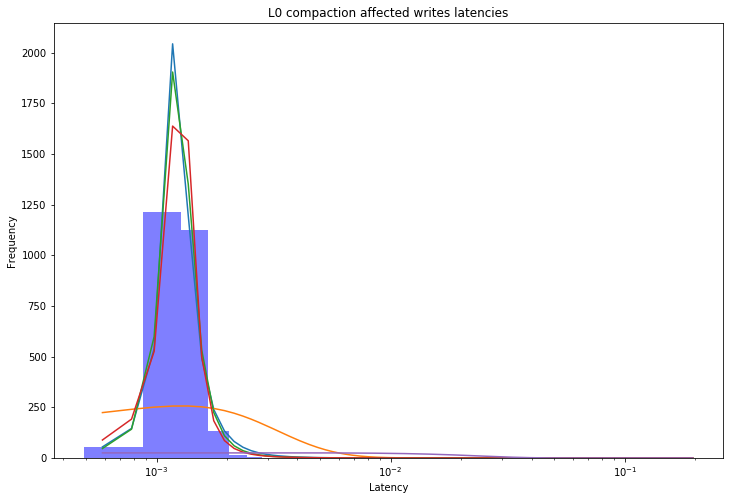

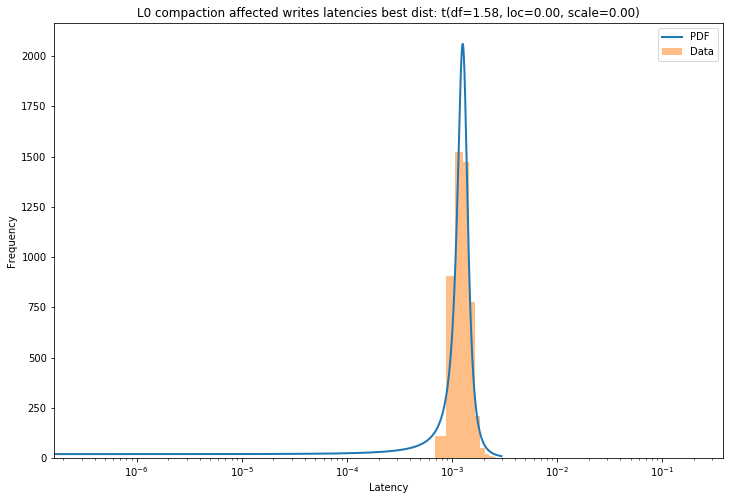

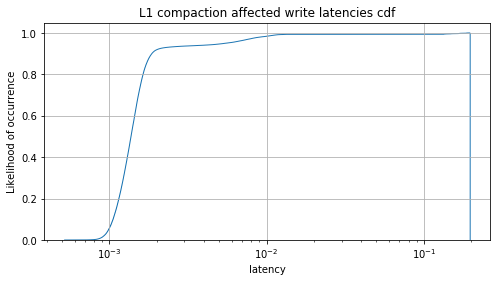

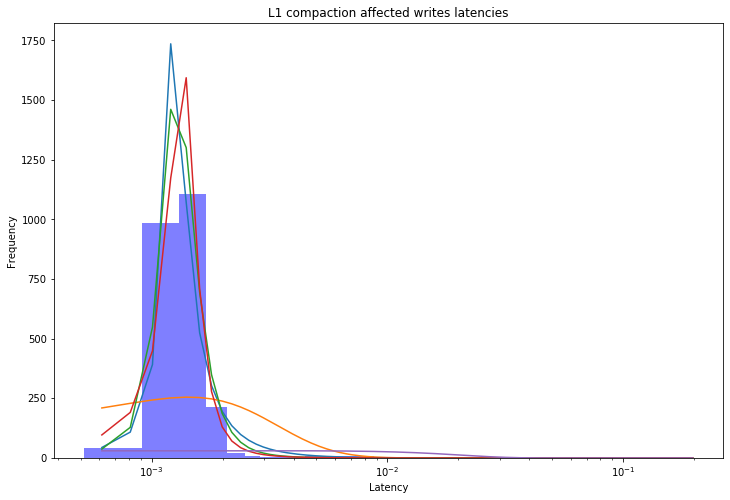

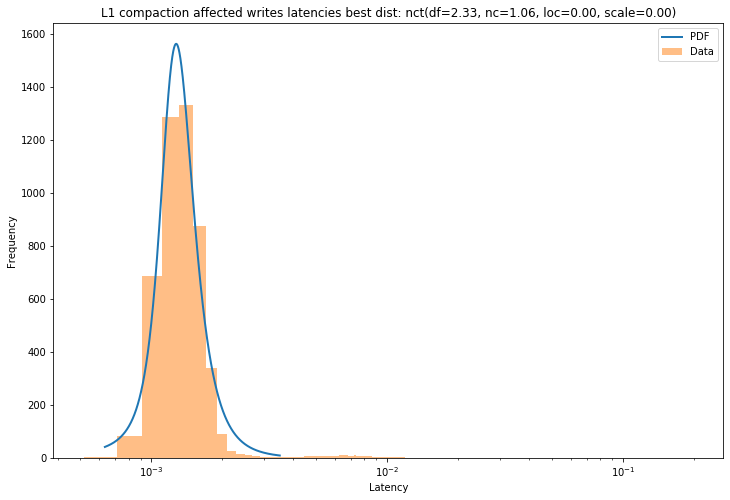

In [22]:
plot_cdf(l0_affected_latencies, 'L0 compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(l0_affected_latencies, 'L0 compaction affected writes latencies', x_log=True)

plot_cdf(l1_affected_latencies, 'L1 compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(l1_affected_latencies, 'L1 compaction affected writes latencies', x_log=True)

# Real compaction

L0 duration:
	 len:37
	 mean:0.1778028918918919
	 median:0.174074
	 variance:6.248998437687688e-05
	 max:0.1937
	 min:0.168443
L1 duration:
	 len:9
	 mean:0.17658544444444446
	 median:0.170855
	 variance:0.00013236723252777786
	 max:0.195534
	 min:0.164748
Other duration:
	 len:9
	 mean:0.14026222222222223
	 median:0.13759100000000002
	 variance:6.0684435694444414e-05
	 max:0.152535
	 min:0.13248200000000002


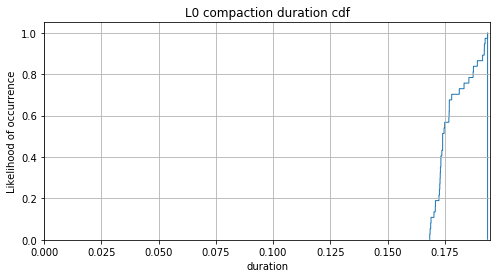

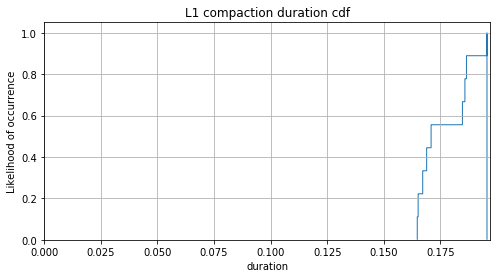

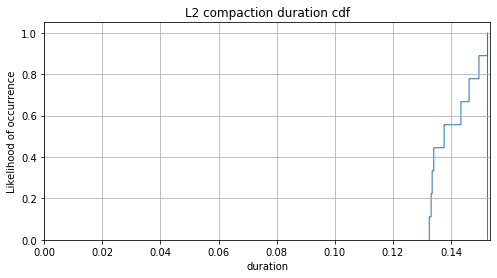

In [32]:
stats(L0_real_compaction_duration, 'L0 duration')
stats(L1_real_compaction_duration, 'L1 duration')
stats(other_real_compaction_duration, 'Other duration')


plot_cdf(L0_real_compaction_duration, 'L0 compaction duration cdf', 'duration', x_log=False)

plot_cdf(L1_real_compaction_duration, 'L1 compaction duration cdf', 'duration', x_log=False)

plot_cdf(other_real_compaction_duration, 'L2 compaction duration cdf', 'duration', x_log=False)

plt.close()

L0 affected latencies:
	 len:1776
	 mean:0.17913268918918918
	 median:0.175709
	 variance:6.096802678559574e-05
	 max:0.19515
	 min:0.161722
L1 affected latencies:
	 len:432
	 mean:0.17783059027777778
	 median:0.17206749999999998
	 variance:0.00011654575782013727
	 max:0.19729
	 min:0.164551
Other affected latencies:
	 len:432
	 mean:0.1415318912037037
	 median:0.13888
	 variance:5.678109980020086e-05
	 max:0.154434
	 min:0.12321


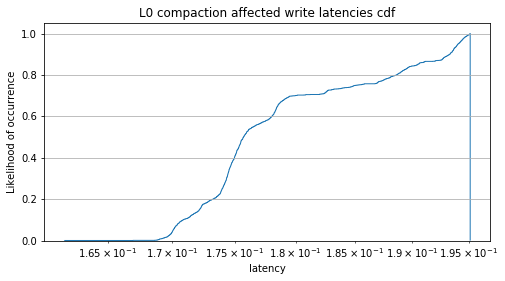

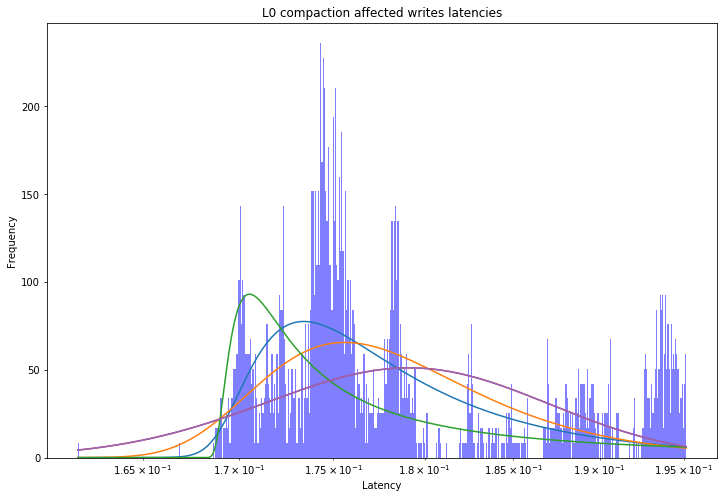

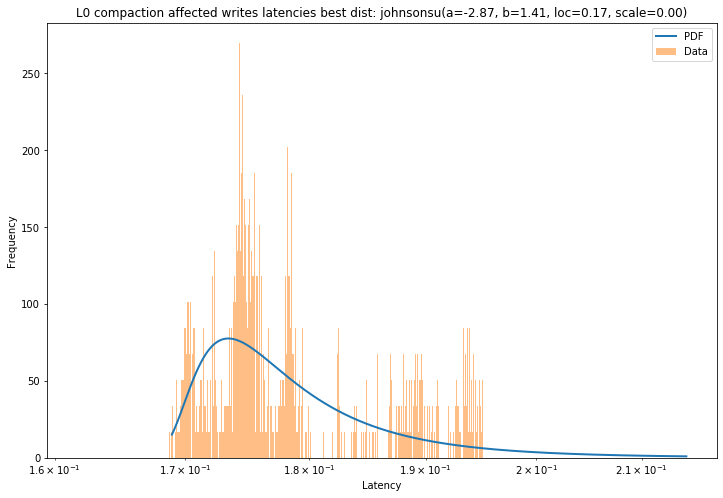

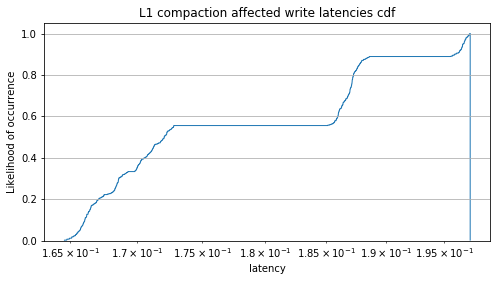

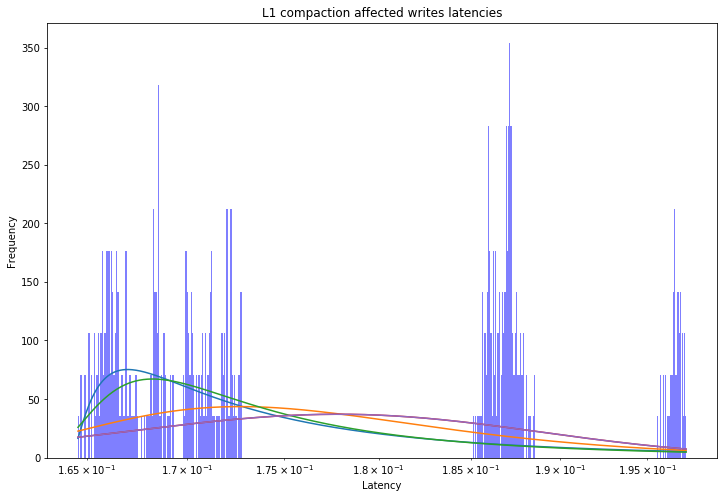

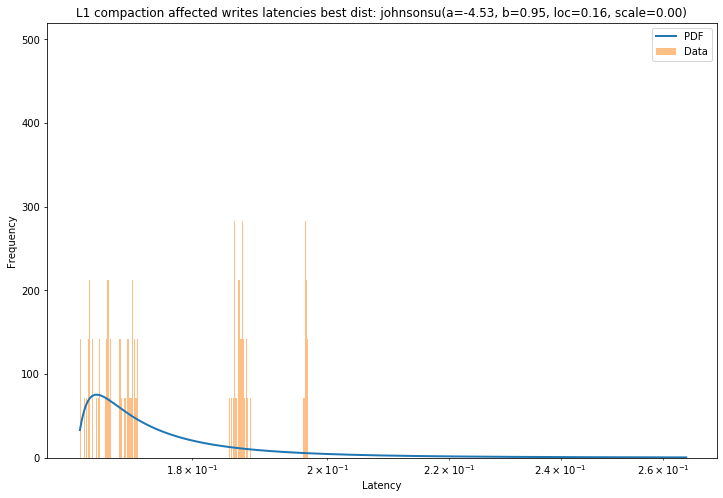

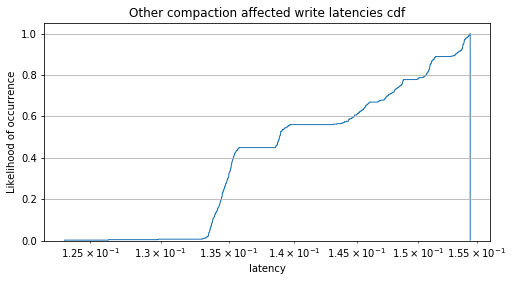

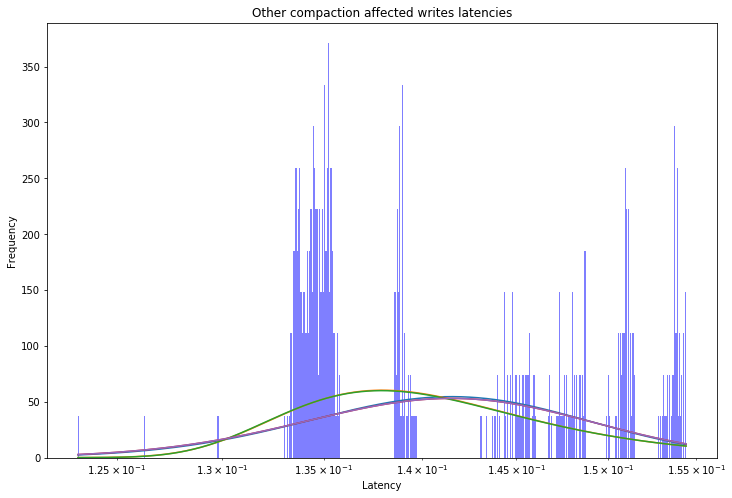

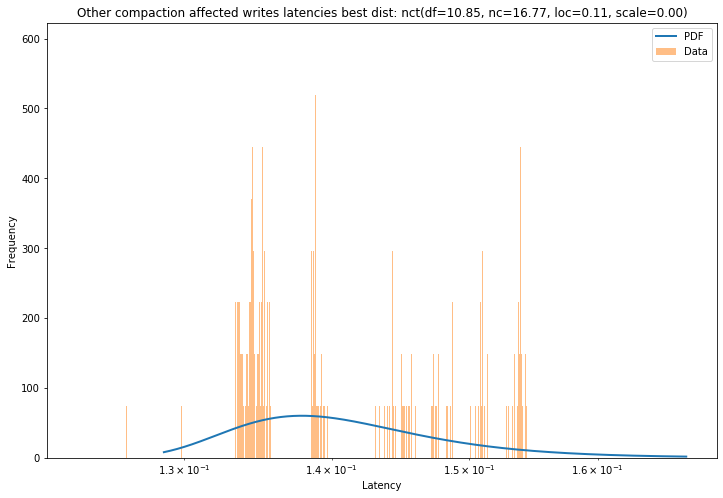

In [30]:
l0_affected_latencies, l1_affected_latencies, other_affected_latencies, other_latencies, l0_compaction_ends, l1_compaction_ends = split_latencies(
    x_bs_lat, y_bs_lat, 
    L0_real_compaction_starts, L0_real_compaction_duration, 
    L1_real_compaction_starts, L1_real_compaction_duration,
    other_compaction_starts = other_real_compaction_starts, other_compaction_durations = other_real_compaction_duration)

stats(l0_affected_latencies, 'L0 affected latencies')
stats(l1_affected_latencies, 'L1 affected latencies')
stats(other_affected_latencies, 'Other affected latencies')


plot_cdf(l0_affected_latencies, 'L0 compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(l0_affected_latencies, 'L0 compaction affected writes latencies', x_log=True)

plot_cdf(l1_affected_latencies, 'L1 compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(l1_affected_latencies, 'L1 compaction affected writes latencies', x_log=True)

plot_cdf(other_affected_latencies, 'Other compaction affected write latencies cdf', 'latency', x_log=True)
find_best_dist(other_affected_latencies, 'Other compaction affected writes latencies', x_log=True)

# write latencies

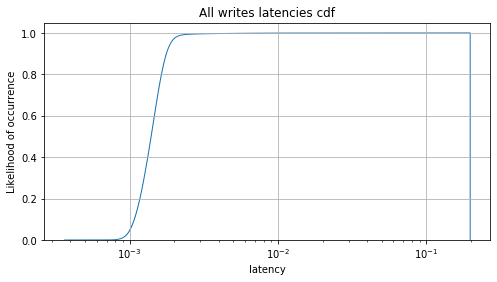

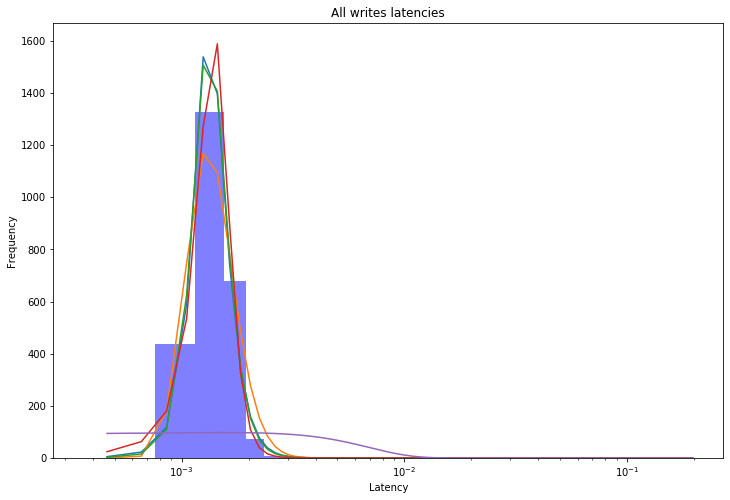

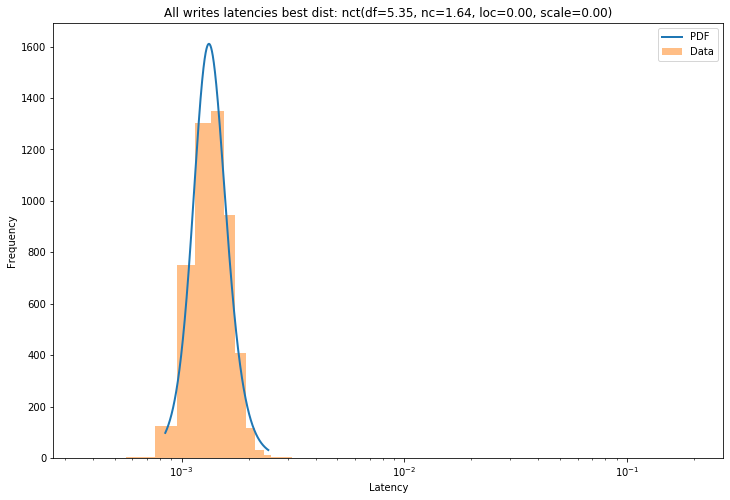

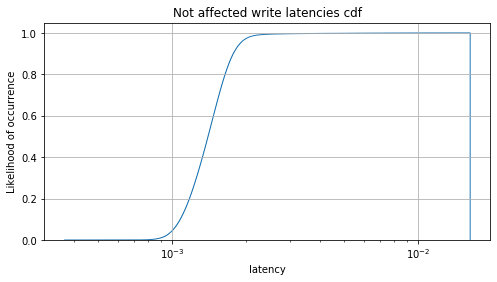

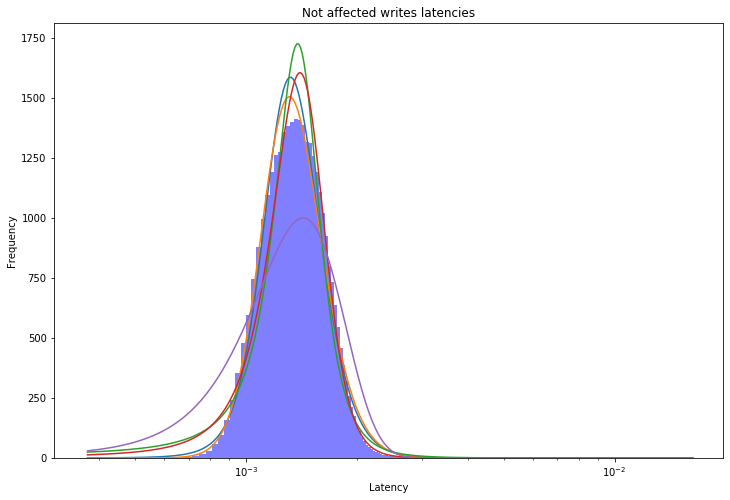

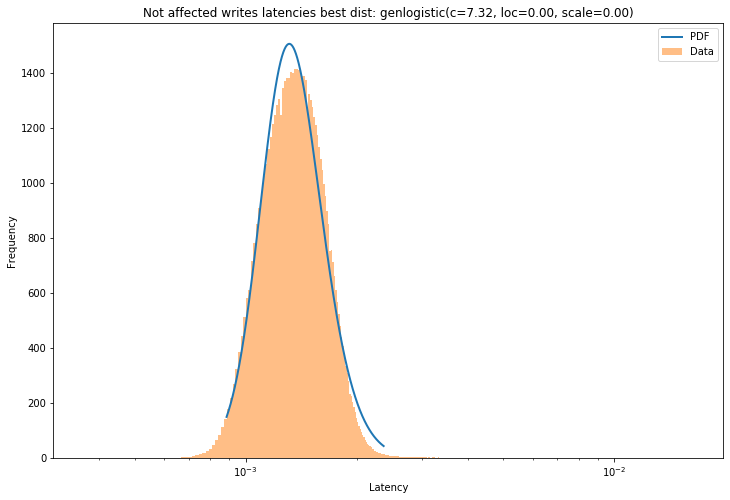

In [31]:
plot_cdf(y_bs_lat, 'All writes latencies cdf', 'latency', x_log=True)
find_best_dist(y_bs_lat, 'All writes latencies', x_log=True)

plot_cdf(other_latencies, 'Not affected write latencies cdf', 'latency', x_log=True)
find_best_dist(other_latencies, 'Not affected writes latencies', x_log=True)

# Latency Model

* If number of writes reaches 124,000, trigger L0 Compaction
    * L0 Compaction duration of 0.174 s (median)
* 25% of L0 Compactions trigger L1, L2, and ...  Compaction
    * L1 Compaction duration of:
        * 55%: 0.165 s
        * 35%: 0.187 s
        * 10%: 0.195 s
    * L2 Compaction duration of 0.137 s (median)
* Latencies affected by compaction:
    * L = compaction duration - relative arrival time + write service time 
* Write latency distribution (Not affected write latencies): Generalized logistic $(c=7.32, loc=0, scale=0)$